In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import torch.nn as nn
import torch.optim as optim

In [2]:
import os
import pandas as pd

file_path = "/home/dl09e24/DATA/TMDB_movie_dataset_v11.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"File not found: {file_path}")

# Load the dataset
df = pd.read_csv(file_path)

In [3]:
print(df.head())

       id            title  vote_average  vote_count    status release_date  \
0   27205        Inception         8.364       34495  Released   2010-07-15   
1  157336     Interstellar         8.417       32571  Released   2014-11-05   
2     155  The Dark Knight         8.512       30619  Released   2008-07-16   
3   19995           Avatar         7.573       29815  Released   2009-12-15   
4   24428     The Avengers         7.710       29166  Released   2012-04-25   

      revenue  runtime  adult                     backdrop_path  ...  \
0   825532764      148  False  /8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg  ...   
1   701729206      169  False  /pbrkL804c8yAv3zBZR4QPEafpAR.jpg  ...   
2  1004558444      152  False  /nMKdUUepR0i5zn0y1T4CsSB5chy.jpg  ...   
3  2923706026      162  False  /vL5LR6WdxWPjLPFRLe133jXWsh5.jpg  ...   
4  1518815515      143  False  /9BBTo63ANSmhC4e6r62OJFuK2GL.jpg  ...   

    original_title                                           overview  \
0        Inception 

In [4]:
features = ['title', 'vote_count', 'runtime', 'revenue', 'popularity']
target = 'vote_average'

In [5]:
df = df[features + [target]].dropna()

In [6]:
bins = [0, 5.5, 7.0, 10.0]
labels = [0, 1, 2]  # 0: BAD, 1: AVG, 2: GOOD
df['vote_category'] = pd.cut(df[target], bins=bins, labels=labels)

In [7]:
print(df['vote_category'].isnull().sum())  # Count the number of NaN values
print(df['vote_category'].unique()) 

784152
[2, 1, 0, NaN]
Categories (3, int64): [0 < 1 < 2]


In [8]:
df['vote_category'].fillna(0, inplace=True)  # Replace NaN with 0 (or another default value)

In [9]:
print(df['vote_category'].isnull().sum())  # Count the number of NaN values
print(df['vote_category'].unique())

0
[2, 1, 0]
Categories (3, int64): [0 < 1 < 2]


In [10]:
df['vote_category'] = df['vote_category'].astype(int)

In [11]:
X = df[features].values
y = df['vote_category'].values

In [12]:
print(df[features].dtypes)  # Check the data types of the features

title          object
vote_count      int64
runtime         int64
revenue         int64
popularity    float64
dtype: object


In [13]:
from sklearn.preprocessing import LabelEncoder

# Encode titles as integers
label_encoder = LabelEncoder()
df['title_encoded'] = label_encoder.fit_transform(df['title'])

# Update the feature list
features = ['title_encoded', 'vote_count', 'runtime', 'revenue', 'popularity']

In [14]:
print(df['title_encoded'].dtype)  # Should be int64 or int32
print(df['title_encoded'].head())  # Inspect the first few rows

int64
0    369707
1    374608
2    753544
3     82553
4    739191
Name: title_encoded, dtype: int64


In [15]:
print(df[features].isnull().sum())  # Check for null values
df = df.dropna(subset=features)  # Drop rows with missing values

title_encoded    0
vote_count       0
runtime          0
revenue          0
popularity       0
dtype: int64


In [16]:
for feature in features:
    print(f"{feature}: {df[feature].dtype}")  # Confirm numeric dtype

title_encoded: int64
vote_count: int64
runtime: int64
revenue: int64
popularity: float64


In [17]:
# Data scaling
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

In [19]:
# 50-50 Train-Test split
train_data, test_data = train_test_split(df, test_size=0.5, random_state=42)

# Extract 5% from Train and Test for Validation
train_data, train_val = train_test_split(train_data, test_size=0.05, random_state=42)
test_data, test_val = train_test_split(test_data, test_size=0.05, random_state=42)

val_data = pd.concat([train_val, test_val])

In [21]:
print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")

Train data size: 538799
Validation data size: 56716
Test data size: 538799


In [22]:
# Extract features and target for train, validation, and test sets
X_train = train_data[features].values
y_train = train_data['vote_category'].values

X_val = val_data[features].values
y_val = val_data['vote_category'].values

X_test = test_data[features].values
y_test = test_data['vote_category'].values

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [23]:
train_data = torch.utils.data.TensorDataset(X_train, y_train)
val_data = torch.utils.data.TensorDataset(X_val, y_val)
test_data = torch.utils.data.TensorDataset(X_test, y_test)

In [24]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

In [25]:
class CNN_LSTM_Model(nn.Module):
    def __init__(self, input_size, num_classes):
        super(CNN_LSTM_Model, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.dropout_cnn = nn.Dropout(0.5)
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        if x.size(-1) > 1:  
            x = self.pool(x)
        x = self.dropout_cnn(x)
        x = x.transpose(1, 2)  
        x, _ = self.lstm(x)
        x = x[:, -1, :]  
        x = self.fc(x)
        return x

In [26]:
input_size = 128  
num_classes = 3  # GOOD, AVG, BAD
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN_LSTM_Model(input_size=input_size, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [29]:
import torch.nn.functional as F

# Training loop with early stopping
epochs = 100
patience = 20
best_val_loss = float('inf')
patience_counter = 0

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == y_batch).sum().item()

    train_accuracy = correct / len(train_loader.dataset)
    train_losses.append(running_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            outputs = model(X_val_batch)
            loss = criterion(outputs, y_val_batch)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == y_val_batch).sum().item()

    val_accuracy = val_correct / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}: Train Loss = {running_loss:.4f}, Train Accuracy = {train_accuracy:.2%}, Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_accuracy:.2%}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

Epoch 1: Train Loss = 4477.7452, Train Accuracy = 81.79%, Validation Loss = 473.2281, Validation Accuracy = 81.60%
Epoch 2: Train Loss = 4448.1716, Train Accuracy = 81.87%, Validation Loss = 476.1851, Validation Accuracy = 81.81%
Epoch 3: Train Loss = 4413.3896, Train Accuracy = 82.05%, Validation Loss = 465.6739, Validation Accuracy = 81.88%
Epoch 4: Train Loss = 4376.7106, Train Accuracy = 82.19%, Validation Loss = 462.1571, Validation Accuracy = 82.09%
Epoch 5: Train Loss = 4336.0535, Train Accuracy = 82.31%, Validation Loss = 460.4127, Validation Accuracy = 82.10%
Epoch 6: Train Loss = 4285.9722, Train Accuracy = 82.38%, Validation Loss = 450.9123, Validation Accuracy = 82.16%
Epoch 7: Train Loss = 4225.2378, Train Accuracy = 82.51%, Validation Loss = 444.8860, Validation Accuracy = 82.28%
Epoch 8: Train Loss = 4165.9305, Train Accuracy = 82.52%, Validation Loss = 438.3180, Validation Accuracy = 82.31%
Epoch 9: Train Loss = 4111.9880, Train Accuracy = 82.58%, Validation Loss = 428.

In [45]:
# Test Accuracy
model.eval()
test_correct, test_loss = 0, 0.0
all_predicted, all_true = [], []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
        outputs = model(X_test_batch)
        loss = criterion(outputs, y_test_batch)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == y_test_batch).sum().item()
        all_predicted.extend(predicted.cpu().numpy())
        all_true.extend(y_test_batch.cpu().numpy())

test_accuracy = test_correct / len(test_loader.dataset)
print(f"Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.2%}")

Test Loss = 2784.7364, Test Accuracy = 83.49%


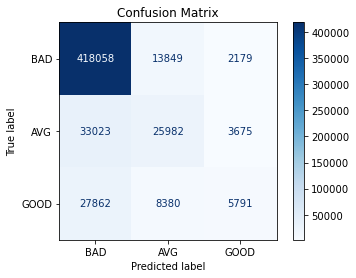

In [47]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion Matrix
cm = confusion_matrix(all_true, all_predicted, labels=[0, 1, 2])
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["BAD", "AVG", "GOOD"])
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error

# MSE calculation
model.eval()
predicted_values = []
true_values = []

with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        X_test_batch = X_test_batch.to(device)
        outputs = model(X_test_batch)
        _, predicted = torch.max(outputs, 1)
        predicted_values.extend(predicted.cpu().numpy())
        true_values.extend(y_test_batch.numpy())

mse = mean_squared_error(true_values, predicted_values)
print(f"Mean Squared Error (MSE): {mse:.4f}")

Mean Squared Error (MSE): 0.3324


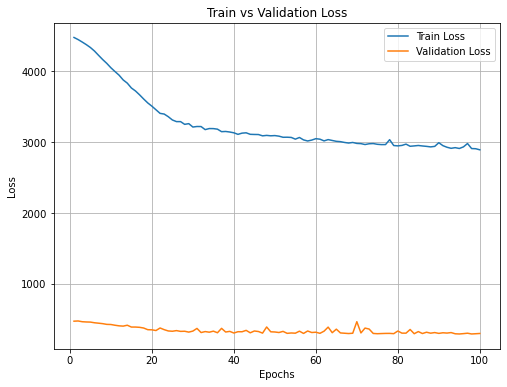

In [49]:
# Plot train vs validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

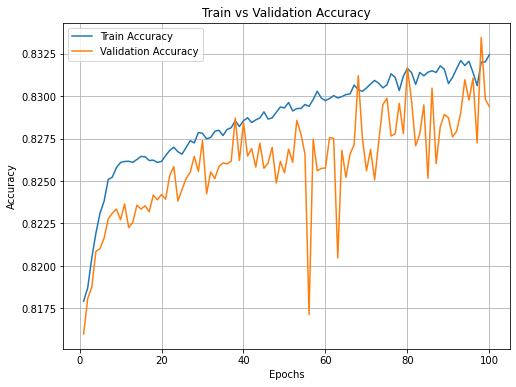

In [50]:
# Plot train vs validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

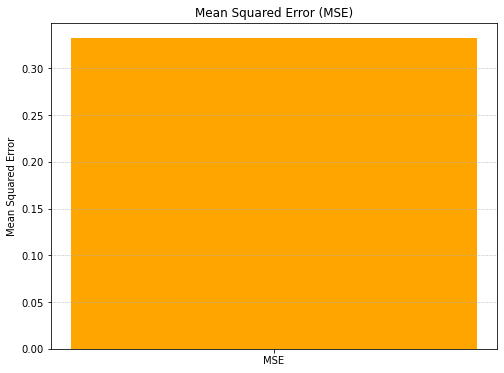

In [52]:
# MSE visualization
plt.figure(figsize=(8, 6))
plt.bar(["MSE"], [mse], color='orange')
plt.ylabel("Mean Squared Error")
plt.title("Mean Squared Error (MSE)")
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.show()

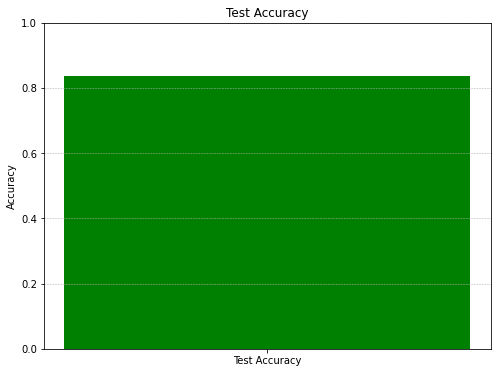

In [53]:
# Test accuracy visualization
plt.figure(figsize=(8, 6))
plt.bar(["Test Accuracy"], [test_accuracy], color='green')
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.show()

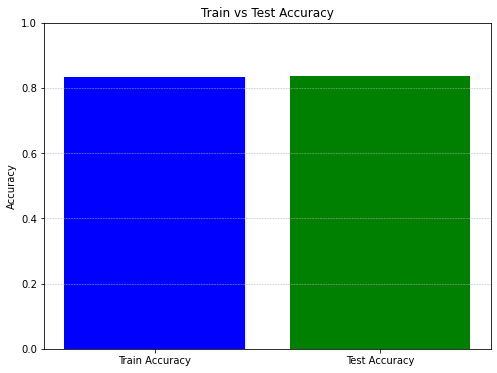

In [54]:
# Plot train vs test accuracy
plt.figure(figsize=(8, 6))
plt.bar(["Train Accuracy", "Test Accuracy"], [train_accuracies[-1], test_accuracy], color=['blue', 'green'])
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy")
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.show()

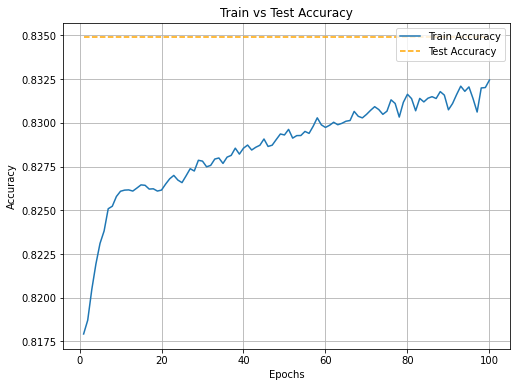

In [57]:
# Plot train vs test accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
plt.hlines(test_accuracy, 1, len(train_accuracies), colors='orange', label="Test Accuracy", linestyles='dashed')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [58]:
# Function to calculate the total number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Display the total number of trainable parameters
total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params}")

Total Trainable Parameters: 80899


In [65]:
# Model parameters table
def show_parameters(model):
    params = [(name, module.__class__.__name__, sum(p.numel() for p in module.parameters() if p.requires_grad))
              for name, module in model.named_children()]
    df = pd.DataFrame(params, columns=["Name", "Type", "Params"])
    print(df)

# Call the function with your model
show_parameters(model)

          Name       Type  Params
0        conv1     Conv1d     128
1         pool  MaxPool1d       0
2        conv2     Conv1d    6208
3        conv3     Conv1d   24704
4  dropout_cnn    Dropout       0
5         lstm       LSTM   49664
6           fc     Linear     195
